<a href="https://colab.research.google.com/github/giulio1809/Toxic_Comment_Classification/blob/main/Toxic_Comment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Mining for Toxic Comments: Text Classification

## Libraries


In [ ]:
# General
import gdown
import zipfile
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from wordcloud import WordCloud
import re
import string
import html
from scipy.stats import loguniform
import joblib

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, make_scorer, roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

# NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('stopwords', quiet=True)

# BERT
from tqdm import tqdm
import transformers
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, DataCollatorWithPadding
import torch
import torch.nn as nn
from torch.utils.data import DataLoader


## Loading Data
Data will be loaded from Google Drive:

In [ ]:
url = 'https://drive.google.com/uc?id=1GV_kAxXAd2lQgwUUQwuRf4CL0MO1_hfR'

# If file not exists, make dir
if not os.path.exists('/content/data'):
  os.mkdir('/content/data')
output = 'jigsaw-toxic-comment-classification-challenge.zip'
gdown.download(url, output, quiet=False)

zip_file = zipfile.ZipFile('jigsaw-toxic-comment-classification-challenge.zip')
zip_file.extractall('data/')
zip_file.close()
os.remove('jigsaw-toxic-comment-classification-challenge.zip')

# Extract all files with .zip in the content folder
for file in os.listdir('/content/data'):
  if file.endswith('.zip'):
    zip_file = zipfile.ZipFile('/content/data/' + file)
    zip_file.extractall('/content/data/')
    zip_file.close()
    os.remove('/content/data/' + file)

Downloading...
From (original): https://drive.google.com/uc?id=1GV_kAxXAd2lQgwUUQwuRf4CL0MO1_hfR
From (redirected): https://drive.google.com/uc?id=1GV_kAxXAd2lQgwUUQwuRf4CL0MO1_hfR&confirm=t&uuid=de2a05f2-9e52-4af6-b43a-c02a65422533
To: /content/jigsaw-toxic-comment-classification-challenge.zip
100%|██████████| 55.2M/55.2M [00:00<00:00, 73.8MB/s]


In [ ]:
train = pd.read_csv('data/train.csv')
print(f"Shape of the Full Training Set: {train.shape})")
train.head()

Shape of the Full Training Set: (159571, 8))


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
X_test = pd.read_csv('data/test.csv')
print(f"Shape of the Test Set (no Labels): {X_test.shape}")
X_test.head()

Shape of the Test Set (no Labels): (153164, 2)


,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
y_test = pd.read_csv('data/test_labels.csv')
print(f"Shape of the Test Set Labels: {y_test.shape}")
y_test.head()

Shape of the Test Set Labels: (153164, 7)


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


## Data Preparation
In this phase, we prepare the data to be explored and then processed by Machine Learning algorithms. More precisely, the steps performed are:
- sanity checks on the Training Set (check for missing values and duplicates);
- drop of the observations having -1 in any label value in the `y_test` (these were set to -1 by the Kaggle challenge provider to avoid manual labelling);
- take Train Set and Test Set in the same format (`X_*` contains the comments text, `y_*` contains the labels).

In [ ]:
print(f"Missing Values in the Train Set per Column:\n{train.isna().sum()}\n")
print(f"Number of duplicates: {train.duplicated().sum()}")

Missing Values in the Train Set per Column:
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

Number of duplicates: 0


In [ ]:
# Drop 'id' Column
X_test = X_test.drop(columns=['id'])
y_test = y_test.drop(columns=['id'])

# Drop observations with -1 in the labels
y_test = y_test[((y_test != -1).all(axis = 1))]
X_test = X_test.iloc[y_test.index]
X_test = X_test['comment_text']

# Reset Indexes
X_test = X_test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [ ]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
X_train, y_train = train['comment_text'], train[labels]

In [ ]:
print(f"Full dataset's dimension: {len(train) + len(X_test)}")
print(f"Train dataset's dimension: {len(train)}")
print(f"Test dataset's dimension: {len(X_test)}")

Full dataset's dimension: 223549
Train dataset's dimension: 159571
Test dataset's dimension: 63978


## Exploratory Data Analysis
In this phase we explore our Train Set; before doing so, we'll add the 'clean' label for better readability (this will be removed during Modeling, since 'clean' is not a valid label for our task).

In [ ]:
y_train['clean'] = 1 - y_train[labels].max(axis=1)

/tmp/ipython-input-907262579.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['clean'] = 1 - y_train[labels].max(axis=1)


In [ ]:
print('Count of Observations per Label in the Train Set:\n')

for label in labels + ['clean']:
    print(f"Number of {label}: {y_train[label].sum()} ({((y_train[label].sum()) / y_train.shape[0] * 100):.2f}%)")

Count of Observations per Label in the Train Set:

Number of toxic: 15294 (9.58%)
Number of severe_toxic: 1595 (1.00%)
Number of obscene: 8449 (5.29%)
Number of threat: 478 (0.30%)
Number of insult: 7877 (4.94%)
Number of identity_hate: 1405 (0.88%)
Number of clean: 143346 (89.83%)


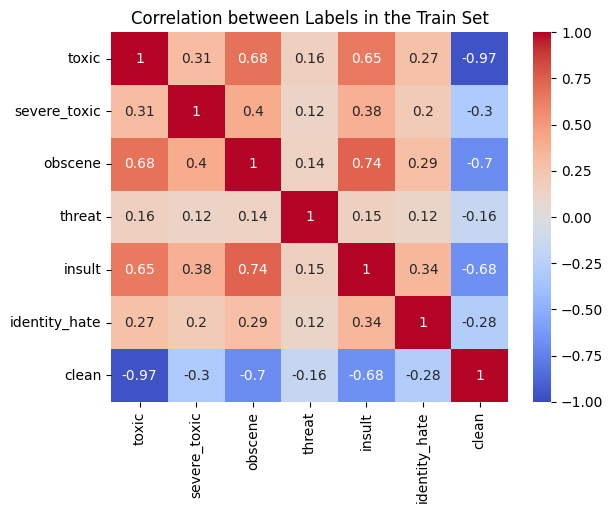

In [ ]:
sns.heatmap(y_train.corr(), annot=True, vmin = -1, vmax = 1, cmap = 'coolwarm')
plt.title('Correlation between Labels in the Train Set')
plt.show()

In [ ]:
for label1, label2 in itertools.combinations(labels, 2):
    print(f"\nCrosstab for {label1} and {label2}:")
    print(pd.crosstab(y_train[label1], y_train[label2], normalize='columns'))


Crosstab for toxic and severe_toxic:
severe_toxic         0    1
toxic                      
0             0.913284  0.0
1             0.086716  1.0

Crosstab for toxic and obscene:
obscene         0         1
toxic                      
0        0.951245  0.061901
1        0.048755  0.938099

Crosstab for toxic and threat:
threat        0         1
toxic                    
0       0.90669  0.060669
1       0.09331  0.939331

Crosstab for toxic and insult:
insult         0         1
toxic                     
0       0.947592  0.067665
1       0.052408  0.932335

Crosstab for toxic and identity_hate:
identity_hate         0        1
toxic                           
0              0.911536  0.07331
1              0.088464  0.92669

Crosstab for severe_toxic and obscene:
obscene              0         1
severe_toxic                    
0             0.999484  0.820452
1             0.000516  0.179548

Crosstab for severe_toxic and threat:
threat               0        1
severe_toxic   

Comparing distribution of text length for each label:

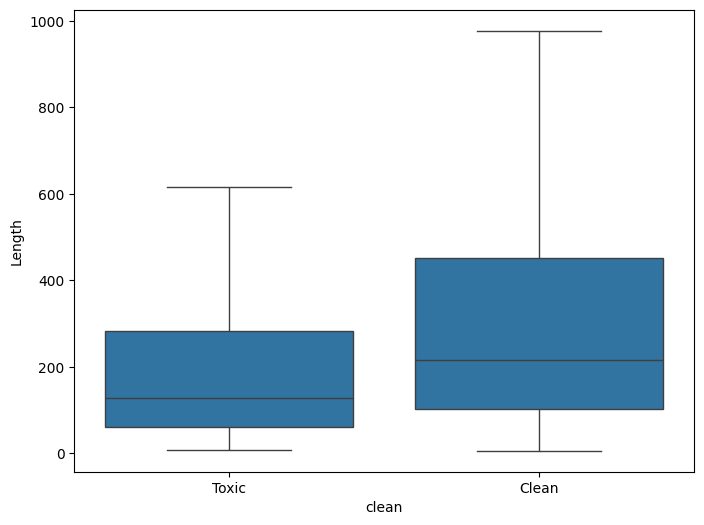

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=y_train['clean'], y=X_train.str.len(), showfliers=False)
plt.xticks([0, 1], ['Toxic', 'Clean'])
plt.ylabel("Length")
plt.show()

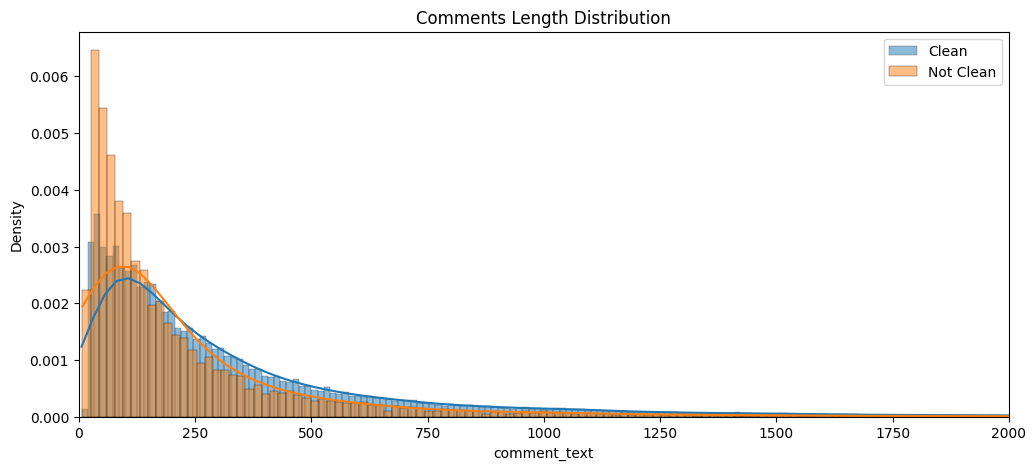

In [ ]:
plt.figure(figsize = (12, 5))

sns.histplot(train[y_train['clean'] == 1]['comment_text'].str.len(), label = 'Clean', kde = True, stat = 'density')
sns.histplot(train[y_train['clean'] == 0]['comment_text'].str.len(), label = 'Not Clean', kde = True, stat = 'density')
plt.title('Comments Length Distribution')
plt.xlim((0, 2000))
plt.legend()
plt.show()

In [ ]:
toxic_comments_index = y_train['clean'] == 0
not_toxic_comments_index = y_train['clean'] == 1
toxic_corpus = ' '.join(X_train[toxic_comments_index])
not_toxic_corpus = ' '.join(X_train[not_toxic_comments_index])

In [ ]:
def censor_text(text):
    # Bad Words to Filter for
    bad_words_list = [
    "fuck", "fucker", "fucking", "fucked", "fucks",
    "shit", "shitty", "shits", "bullshit",
    "bitch", "bitches", "bitching",
    "asshole", "asses", "arse", "arsehole", "buttsecks", "anal", "ass",
    "bastard", "bastards",
    "cock", "cocksucker", "dick", "dickhead", "prick",
    "pussy", "cunt", "twat", "wanker",
    "bj", "blowjob", "cum", "suck",
    "whore", "slut",
    "moron", "dumbass",
    "retard", "retarded",
    "nigger", "nigga", "niggers",
    "fag", "faggot", "faggots", "fags", "tranny",
    ]

    # Pattern to Spot any of the Above
    pattern_str = r'\b(' + '|'.join(map(re.escape, bad_words_list)) + r')\b'

    # Replacement Function for each match
    def replacement_func(match):
        word = match.group()
        # Edge case: if word is too short (e.g. 1 letter), just return '*'
        if len(word) < 2:
            return "*" * len(word)

        # Standard censoring: Keep first/last letter, fill middle with *
        return word[0] + "*" * (len(word) - 2) + word[-1]

    # Replace patterns with replacement
    return re.sub(pattern_str, replacement_func, text, flags=re.IGNORECASE)

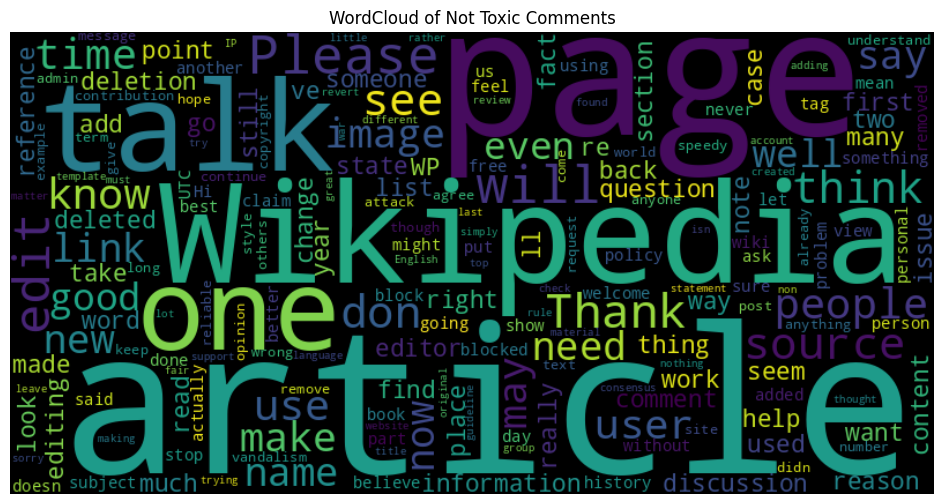

In [ ]:
# Generate a word cloud image
wordcloud = WordCloud(width = 800, height = 400, regexp = r"\w+\**\w+", collocation_threshold = 1e5, random_state = 42).generate(not_toxic_corpus)

# Display the generated image:
plt.figure(figsize = (16, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('WordCloud of Not Toxic Comments')
plt.axis("off")
plt.show()

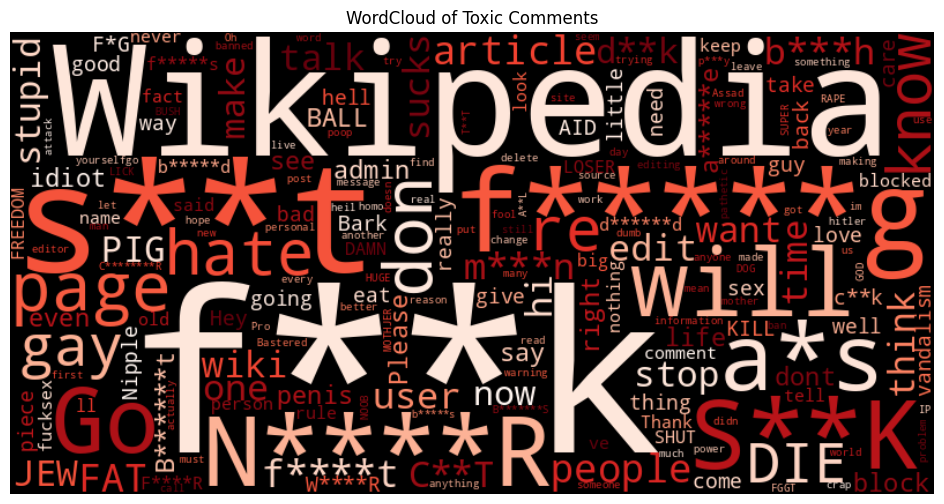

In [ ]:
# Generate a word cloud image
wordcloud = WordCloud(width = 800, height = 400, regexp = r"\w+\**\w+", colormap = 'Reds', collocation_threshold = 1e5, random_state = 42).generate(censor_text(toxic_corpus))

# Display the generated image:
plt.figure(figsize = (16, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('WordCloud of Toxic Comments')
plt.axis("off")
plt.show()

Since we used the `"clean"` label just for visualization, we'll drop it now:

In [ ]:
y_train = y_train.drop(columns='clean')

# Statistical Methods

## Data Cleaning

We'll now define a custom `clean_text` function which applies some preprocessing techniques, tokenization, lemmatization and stop words removal.

In [ ]:
def preprocessor(text):
    # Remove Double Whitespaces, Newlines, Tabs
    text = re.sub(r'\s+', ' ', text)

    # Remove Links, such as http, www, .com
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove IP Addresses
    text = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', '', text)

    # Remove tag/mention (@user)
    text = re.sub(r'@\w+', '', text)

    # Remove Character Repetitions
    pattern_alpha = re.compile(r"([A-Za-z])\1{2,}", re.DOTALL)
    text = pattern_alpha.sub(r"\1\1", text)

    return text

def lemmatizer_and_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    return [
        lemmatizer.lemmatize(t)
        for t in tokens
        if t.lower() not in stop_words
    ]

def clean_text(text, lemmatization = True):
    # Preprocessing
    text = preprocessor(text)

    # Tokenization
    tokens = word_tokenize(text)

    # Lemmatization
    if lemmatization:
      tokens = lemmatizer_and_stopwords(tokens)

    return ' '.join(tokens)

In [ ]:
X_train_clean = X_train.apply(clean_text, lemmatization = True)
X_test_clean = X_test.apply(clean_text, lemmatization = True)

## Metrics
During training and hyperparameters fine-tuning, we aimed to maximize the ROC AUC, which measures the model's intrinsic ability to discriminate between positives and negatives across all possible thresholds. Once this has been done, a threshold tuning phase will be performed to find the optimal threshold to maximize the F1, which is the harmonic mean between Precision and Recall, making it a suitable metric to have a sense of our models' performance.

Below, we define an AUC scorer which uses the Decision Function (instead of the standard Estimated Class Probabilities), to enable to compute AUC for those models which don't estimate class probabilities (e.g., LinearSVC).

In [ ]:
auc_scorer = make_scorer(roc_auc_score, response_method="decision_function")

## Count Vectorizer
We'll first try to train a model on the raw counts of tokens in the dataset; these counts are extracted from the `CountVectorizer` class (no significant differences in using or not using our `preprocessing`):

### Naive Bayes

In [ ]:
pipeline = Pipeline([
    ('tfidf', CountVectorizer()),
    ('clf', OneVsRestClassifier(MultinomialNB()))
])

auc_scores = cross_val_score(pipeline, X_train_clean, y_train, cv=5, scoring='roc_auc_ovr')
print(f"Mean AUC: {auc_scores.mean():.4f}")

Mean AUC: 0.8720


In [ ]:
pipeline = Pipeline([
    ('tfidf', CountVectorizer()),
    ('clf', OneVsRestClassifier(ComplementNB()))
])

auc_scores = cross_val_score(pipeline, X_train_clean, y_train, cv=5, scoring='roc_auc_ovr')
print(f"Mean AUC: {auc_scores.mean():.4f}")

Mean AUC: 0.8720


## TF-IDF


### Logistic Regression

In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', OneVsRestClassifier(LogisticRegression(class_weight='balanced', random_state = 42)))
])

auc_scores = cross_val_score(pipeline, X_train_clean, y_train, cv=5, scoring='roc_auc_ovr')
print(f"Mean AUC: {auc_scores.mean():.4f}")

Mean AUC: 0.9797


### LinearSVC


In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', OneVsRestClassifier(LinearSVC(class_weight = 'balanced', max_iter = 5_000, random_state = 42)))
])

auc_scores = cross_val_score(pipeline, X_train_clean, y_train, cv=5, scoring=auc_scorer)
print(f"Mean AUC: {auc_scores.mean():.4f}")

Mean AUC: 0.9688


### SGD
Stochastic Gradient Descent is a general optimization algorithm, which can be used to both implement Logistic Regression or Linear SVC based on which function we ask it to optimize (respectively Log Loss and Hinge Loss).

We'll implement a RandomizedSearch to allow the SGD to automatically choose which of the 2 Loss (and so which of the 2 models) is best suited for our task:

In [ ]:
# Log Loss -> Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', OneVsRestClassifier(SGDClassifier(loss = 'log_loss', class_weight = 'balanced', random_state = 42)))
])

auc_scores = cross_val_score(pipeline, X_train_clean, y_train, cv=5, scoring='roc_auc_ovr')
print(f"Mean AUC: {auc_scores.mean():.4f}")

Mean AUC: 0.9769


In [ ]:
# Hinge Loss -> Linear SVC
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', OneVsRestClassifier(SGDClassifier(loss = 'hinge', class_weight = 'balanced', random_state = 42)))
])

auc_scores = cross_val_score(pipeline, X_train_clean, y_train, cv=5, scoring=auc_scorer)
print(f"Mean AUC: {auc_scores.mean():.4f}")

Mean AUC: 0.9794


## Parameter Tuning on the Best Tfidf-based Model

In [ ]:
# Logistic Regression

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', OneVsRestClassifier(LogisticRegression(class_weight='balanced', random_state = 42)))
])

params = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__min_df': [1, 2, 3],
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'clf__estimator__C': loguniform(1e-2, 1e2)
    }

grid = RandomizedSearchCV(pipeline, params, n_iter = 10, cv=5, scoring=auc_scorer, random_state=42)
grid.fit(X_train_clean, y_train)

print(f"Best estimator of the grid with parameters: {grid.best_params_}")
print(f"Model's AUC: {grid.best_score_:.4f}")
best_score = grid.best_score_
best_model = grid.best_estimator_


Best estimator of the grid with parameters: {'clf__estimator__C': np.float64(1.256315277393867), 'tfidf__max_df': 1.0, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Model's AUC: 0.9806


In [ ]:
# SGD

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', OneVsRestClassifier(SGDClassifier(class_weight = 'balanced', max_iter = 100_000, early_stopping = True, n_iter_no_change = 5, validation_fraction = 0.1, random_state = 42)))
])

params = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__min_df': [1, 2, 3],
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'clf__estimator__loss': ['hinge', 'log_loss'],
    'clf__estimator__alpha': [1e-6, 1e-5, 1e-4]
}

grid = RandomizedSearchCV(pipeline, params, n_iter = 10, cv=5, scoring=auc_scorer, random_state=42)
grid.fit(X_train_clean, y_train)

print(f"Best estimator of the grid with parameters: {grid.best_params_}")
print(f"Model's AUC: {grid.best_score_:.4f}\n")
if grid.best_score_ > best_score:
  print(f'This is better than previous best score of {best_score} so I\'m saving the model')
  best_score = grid.best_score_
  best_model = grid.best_model
else:
  print(f'This is worse than previous best score of {best_score} so I\'m not saving the model\n')

print(f'Final Model\'s parameters: {best_model}')
print(f'Final Model\'s score: {best_score}')

Best estimator of the grid with parameters: {'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 3, 'tfidf__max_df': 0.5, 'clf__estimator__loss': 'hinge', 'clf__estimator__alpha': 0.0001}
Model's AUC: 0.9797

This is worse than previous best score of 0.9806352426817029 so I'm not saving the model

Final Model's parameters: Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=2, ngram_range=(1, 2))),
                ('clf',
                 OneVsRestClassifier(estimator=LogisticRegression(C=np.float64(1.256315277393867),
                                                                  class_weight='balanced',
                                                                  random_state=42)))])
Final Model's score: 0.9806352426817029


In [ ]:
best_model

Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=2, ngram_range=(1, 2))),
                ('clf',
                 OneVsRestClassifier(estimator=LogisticRegression(C=np.float64(1.256315277393867),
                                                                  class_weight='balanced',
                                                                  random_state=42)))])

## Threshold Tuning

In [ ]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

def find_optimal_thresholds(y_true, y_probs):
    best_thresholds = []
    best_f1_scores = []

    # Loop over each label (column)
    for i in range(y_true.shape[1]):
        y_true_col = y_true[:, i]
        y_prob_col = y_probs[:, i]

        # We will test thresholds from 0.01 to 0.99
        thresholds = np.arange(0.01, 1.0, 0.01)
        f1_scores = []

        for thresh in thresholds:
            # Create hard predictions based on current threshold
            y_pred_thresh = (y_prob_col >= thresh).astype(int)
            f1_scores.append(f1_score(y_true_col, y_pred_thresh))

        # Find max F1 and the threshold that generated it
        max_f1 = max(f1_scores)
        best_thresh = thresholds[np.argmax(f1_scores)]

        best_thresholds.append(best_thresh)
        best_f1_scores.append(max_f1)

        print(f"Label {labels[i]}: Best Threshold={best_thresh:.2f}")
    print('Best thresholds successfully saved')

    return np.array(best_thresholds)

In [ ]:
y_proba_cv = cross_val_predict(best_model, X_train_clean, y_train, cv=5, method='predict_proba')

In [ ]:
optimal_thresholds = find_optimal_thresholds(y_train.values, y_proba_cv)

Label toxic: Best Threshold=0.67
Label severe_toxic: Best Threshold=0.88
Label obscene: Best Threshold=0.66
Label threat: Best Threshold=0.88
Label insult: Best Threshold=0.71
Label identity_hate: Best Threshold=0.87
Best thresholds successfully saved


## Saving Model and Optimal Thresholds

In [ ]:
save_model = True # put it to True if you want to save actual model configuration

if save_model:
  # Define configuration
  checkpoint = {
      'model': best_model,
      'thresholds': optimal_thresholds
  }

  # Create Folder
  os.makedirs('./ML_model')

  # Load Configuration
  joblib.dump(checkpoint, './ML_model/logistic_regression_tuned.pkl')
  print("Model and thresholds saved successfully.")

Model and thresholds saved successfully.


## Loading Model and Optimal Thresholds

In [ ]:
load_model = True # put it to True if you want to load model configuration

if load_model:
  # Define Folder
  folder = './ML_model'

  # Create Folder if doesn't exist
  if not os.path.exists(folder):
    os.makedirs(folder)

  # Try to load model
  try:
    imported_data = joblib.load('./ML_model/logistic_regression_tuned.pkl')
    model = imported_data['model']
    thresholds = imported_data['thresholds']
  except OSError:
    print(f'Model file not found.\nBe sure to have a .pkl inside {folder}')

## Final Evaluation with Test Set

In [ ]:
def evaluate_model(model, y_test, optimal_thresholds = np.full(6, 0.5)):
    y_prob = model.predict_proba(X_test)
    y_pred = (y_prob >= optimal_thresholds).astype(int)
    print(classification_report(y_test, y_pred, target_names=labels, zero_division=0))
    auc = roc_auc_score(y_test, y_prob, average = None)
    print("AUC per label:")
    for i in range(len(labels)):
      print(f"{labels[i]}: {auc[i]:.4f}")
    print(f"\nMean ROC-AUC: {auc.mean():.4f}")
    print(f"Macro-Averaged F1: {f1_score(y_test, y_pred, average = 'macro'):.2f}")

In [ ]:
evaluate_model(best_model, y_test, optimal_thresholds)

               precision    recall  f1-score   support

        toxic       0.48      0.75      0.59      6090
 severe_toxic       0.27      0.50      0.35       367
      obscene       0.51      0.69      0.59      3691
       threat       0.38      0.39      0.38       211
       insult       0.57      0.61      0.59      3427
identity_hate       0.53      0.46      0.49       712

    micro avg       0.50      0.68      0.57     14498
    macro avg       0.46      0.57      0.50     14498
 weighted avg       0.50      0.68      0.57     14498
  samples avg       0.06      0.06      0.06     14498

AUC per label:
toxic: 0.9350
severe_toxic: 0.9822
obscene: 0.9496
threat: 0.9793
insult: 0.9499
identity_hate: 0.9747

Mean ROC-AUC: 0.9618
Macro-Averaged F1: 0.50


# BERT


In [ ]:
validation = False # set it to True if you want to hold-out some data to evaluate the model, set it to False if you are already happy with the final model

Let's define a simple preprocessor which is suitable for DistilBERT.

In [ ]:
def preprocessor(text):
    # Decode HTML entities ("&amp;" -> "&", "&quot;" -> '"')
    text = html.unescape(text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove Links, such as http, www, .com
    text = re.sub(r'http\S+|www\S+', 'http', text)

    # Remove IP Addresses
    text = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', '', text)

    # Mask tag/mention with 'user'
    text = re.sub(r'@\w+', 'user', text)

    # Remove Character Repetitions
    pattern_alpha = re.compile(r"([A-Za-z])\1{2,}", re.DOTALL)
    text = pattern_alpha.sub(r"\1\1", text)

    # Final cleanup which removes Double Whitespaces, Newlines, Tabs
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
# Training and Validation sets

if validation:
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

print(f"Training Samples: {len(X_train)}")
if validation:
    print(f"Validation Samples: {len(X_val)}")
print(f"Test Samples: {len(X_test)}")

Training Samples: 159571
Test Samples: 63978


### Hyperparameters

In [ ]:
MAX_LEN = 256 # tried 128
TRAIN_BATCH_SIZE = 32 # tried with 16
VALID_BATCH_SIZE = TRAIN_BATCH_SIZE*2 # tried with 16
EPOCHS = 2 # tried with 1 and 3
LEARNING_RATE = 2e-05 # tried with 1e-05
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

# Seeds
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)


### Preprocessing

In [ ]:
def convert_labels(row):
  return [row[l] for l in labels]

In [ ]:
preprocessing = True

In [ ]:
# Training set
train = X_train.to_frame()
train['labels'] = y_train.apply(convert_labels, axis = 1)
train = train.reset_index(drop = True)

# Test set
test = X_test.to_frame()

# Validation set
if validation:
  val = X_val.to_frame()
  val['labels'] = y_val.apply(convert_labels, axis = 1)
  val = val.reset_index(drop = True)

# Preprocessing
if preprocessing:
    train['comment_text'] = train['comment_text'].apply(preprocessor)
    test['comment_text'] = test['comment_text'].apply(preprocessor)
    if validation:
        val['comment_text'] = val['comment_text'].apply(preprocessor)


### Tokenizer

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Padding
Now we create a batch of examples using DataCollatorWithPadding. It’s more efficient to dynamically pad the sentences to the longest length in a batch during collation, instead of padding the whole dataset to the maximum length.

In [ ]:

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Data Loader

In [ ]:
class MultiLabelDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, new_data=False):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.comment_text
        self.max_len = max_len
        self.new_data = new_data
        if not self.new_data:
            self.targets = self.data.labels

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation = True,
            padding = False,
            return_tensors=None
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']


        item = {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'attention_mask': torch.tensor(mask, dtype=torch.long)
        }

        if not self.new_data:
            item['targets'] = torch.tensor(self.targets[index], dtype=torch.float)

        return item

In [ ]:
# Training set
training_set = MultiLabelDataset(train, tokenizer, MAX_LEN)

train_params ={
    'batch_size': TRAIN_BATCH_SIZE,
    'shuffle': True,
    'num_workers': 2,
    'pin_memory': True, # Faster transfer to GPU (CUDA) in CPU-to-GPU transfer
    'collate_fn': data_collator
}

training_loader = DataLoader(training_set, **train_params)

# Validation set
if validation:
    validation_set = MultiLabelDataset(val, tokenizer, MAX_LEN)

    valid_params = {
        'batch_size': VALID_BATCH_SIZE,
        'shuffle': False,
        'num_workers': 2,
        'pin_memory': True,
        'collate_fn': data_collator
    }

    valid_loader = DataLoader(validation_set, **valid_params)


# Test set
test_set = MultiLabelDataset(test, tokenizer, MAX_LEN, new_data = True)

test_params = {
    'batch_size': VALID_BATCH_SIZE,
    'shuffle': False,
    'num_workers': 2,
    'pin_memory': True,
    'collate_fn': data_collator
}

test_loader = DataLoader(test_set, **test_params)

### Model

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",
                                                            num_labels = len(labels),
                                                            problem_type="multi_label_classification")
model.to(DEVICE)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


### Loss Function and Optimizer

In [ ]:
'''# We tried with weighted BCE loss aswell
# Custom weighted BCE Loss
positive_count = y_train.sum()
negative_count = len(y_train) - positive_count
class_weights = torch.tensor((negative_count / positive_count).values).to(DEVICE)

def loss_fn(outputs, targets):
    return nn.BCEWithLogitsLoss(pos_weight = class_weights)(outputs, targets)
'''

# Unweighted BCE Loss
def loss_fn(outputs, targets):
    return nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
'''# We tried with default Adam aswell
# optimizer = torch.optim.Adam(params = model.parameters(), lr=LEARNING_RATE)
'''
# AdamW for weight decay
optimizer = torch.optim.AdamW(params = model.parameters(), lr = LEARNING_RATE, weight_decay = 0.01)

In [ ]:
total_steps = len(training_loader) * EPOCHS
# n_warmup_steps = int(0.1 * total_steps)

# Scheduler for weight decay
scheduler = transformers.get_linear_schedule_with_warmup(optimizer,
                                                         num_warmup_steps= 0, # we tried n_warmup_steps = n_warmup_steps
                                                         num_training_steps=total_steps)

### Training Function

In [ ]:
def train_one_epoch(training_loader, model, loss_fn, optimizer, scheduler, epoch, DEVICE):
    model.train()
    epoch_loss = 0.0
    for i, data in tqdm(enumerate(training_loader)):
        ids = data['input_ids'].to(DEVICE, dtype = torch.long)
        mask = data['attention_mask'].to(DEVICE, dtype = torch.long)
        targets = data['targets'].to(DEVICE, dtype = torch.float)

        outputs = model(input_ids = ids, attention_mask = mask)
        logits = outputs.logits

        optimizer.zero_grad()
        loss = loss_fn(logits, targets)
        loss.backward()
        # Try gradient clipping, avoiding exploding gradients risks
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        if i%200==0:
          print(f'Epoch: {epoch + 1} / {EPOCHS}, Training Loss:  {loss.item()}')

        epoch_loss += loss.item()

    return epoch_loss / len(training_loader)

### Validation Function

Validation including computations for F1, ROC-AUC and Threshold Tuning.

In [ ]:
def validate_one_epoch(val_loader, model, loss_fn, optimizer, scheduler, epoch, DEVICE):
    model.eval()
    running_loss = 0.0

    # Store all results for the whole epoch
    final_targets = []
    final_outputs = []

    with torch.no_grad():
        for i, data in enumerate(val_loader):
            ids = data['input_ids'].to(DEVICE, dtype=torch.long)
            mask = data['attention_mask'].to(DEVICE, dtype=torch.long)
            targets = data['targets'].to(DEVICE, dtype=torch.float)

            # Forward Pass
            outputs = model(input_ids = ids, attention_mask = mask)
            logits = outputs.logits

            # Calculate Loss batch-wise
            running_loss += loss_fn(logits, targets).item()

            # Store predictions and labels for later
            # We move them to CPU to prevent GPU out of memory errors
            final_targets.extend(targets.cpu().numpy())
            final_outputs.extend(torch.sigmoid(logits).cpu().numpy())

    # Overall metrics calculation
    final_targets = np.array(final_targets)
    final_outputs = np.array(final_outputs)

    final_preds = (final_outputs > 0.5).astype(int)

    epoch_loss = running_loss / len(val_loader)
    epoch_f1 = f1_score(final_targets, final_preds, average='macro')
    epoch_auc = roc_auc_score(final_targets, final_outputs, average=None)

    return epoch_loss, epoch_f1, epoch_auc, final_outputs, final_targets

In [ ]:
training_loss = []
val_loss = []

for epoch in range(EPOCHS):
    print('-'*80)
    training_loss.append(train_one_epoch(training_loader, model, loss_fn, optimizer, scheduler, epoch, DEVICE))
    if validation:
        # Validation for the whole set
        avg_val_loss, val_f1, val_auc, val_probs, val_targets = validate_one_epoch(valid_loader, model, loss_fn, optimizer, scheduler, epoch, DEVICE)
        val_loss.append(avg_val_loss)

        print(f"Epoch {epoch+1} Summary:")
        print(f"  Avg Validation Loss: {avg_val_loss:.4f}")
        print(f"  Macro F1: {val_f1:.4f}")
        print(f"  ROC AUC: {val_auc.mean():.4f}")


--------------------------------------------------------------------------------


1it [00:01,  1.19s/it]

Epoch: 1 / 2, Training Loss:  0.6904613971710205


201it [02:04,  1.54it/s]

Epoch: 1 / 2, Training Loss:  0.0477442592382431


401it [04:16,  1.49it/s]

Epoch: 1 / 2, Training Loss:  0.06140633672475815


601it [06:27,  1.51it/s]

Epoch: 1 / 2, Training Loss:  0.027281522750854492


801it [08:40,  1.50it/s]

Epoch: 1 / 2, Training Loss:  0.06406501680612564


1001it [10:51,  1.61it/s]

Epoch: 1 / 2, Training Loss:  0.06520608067512512


1201it [13:02,  1.51it/s]

Epoch: 1 / 2, Training Loss:  0.0286596417427063


1401it [15:14,  1.50it/s]

Epoch: 1 / 2, Training Loss:  0.03154519200325012


1601it [17:25,  1.56it/s]

Epoch: 1 / 2, Training Loss:  0.06006520241498947


1801it [19:36,  1.52it/s]

Epoch: 1 / 2, Training Loss:  0.014151453040540218


2001it [21:47,  1.50it/s]

Epoch: 1 / 2, Training Loss:  0.06009133905172348


2201it [23:58,  1.67it/s]

Epoch: 1 / 2, Training Loss:  0.03467431664466858


2401it [26:09,  1.50it/s]

Epoch: 1 / 2, Training Loss:  0.17233186960220337


2601it [28:20,  1.50it/s]

Epoch: 1 / 2, Training Loss:  0.10153482854366302


2801it [30:31,  1.52it/s]

Epoch: 1 / 2, Training Loss:  0.024083968251943588


3001it [32:41,  1.73it/s]

Epoch: 1 / 2, Training Loss:  0.047996215522289276


3201it [34:53,  1.50it/s]

Epoch: 1 / 2, Training Loss:  0.04209038242697716


3401it [37:05,  1.50it/s]

Epoch: 1 / 2, Training Loss:  0.042625874280929565


3601it [39:17,  1.50it/s]

Epoch: 1 / 2, Training Loss:  0.08454103767871857


3801it [41:29,  1.51it/s]

Epoch: 1 / 2, Training Loss:  0.023119179531931877


4001it [43:40,  1.50it/s]

Epoch: 1 / 2, Training Loss:  0.039582908153533936


4201it [45:51,  1.56it/s]

Epoch: 1 / 2, Training Loss:  0.053173840045928955


4401it [48:03,  1.59it/s]

Epoch: 1 / 2, Training Loss:  0.06347467750310898


4601it [50:13,  1.67it/s]

Epoch: 1 / 2, Training Loss:  0.03609186410903931


4801it [52:24,  1.51it/s]

Epoch: 1 / 2, Training Loss:  0.0587000772356987


4987it [54:26,  1.53it/s]

--------------------------------------------------------------------------------



1it [00:00,  1.76it/s]

Epoch: 2 / 2, Training Loss:  0.047333329916000366


201it [02:11,  1.62it/s]

Epoch: 2 / 2, Training Loss:  0.008292829617857933


401it [04:22,  1.52it/s]

Epoch: 2 / 2, Training Loss:  0.04504796117544174


601it [06:34,  1.50it/s]

Epoch: 2 / 2, Training Loss:  0.056001096963882446


801it [08:45,  1.51it/s]

Epoch: 2 / 2, Training Loss:  0.024289293214678764


1001it [10:56,  1.50it/s]

Epoch: 2 / 2, Training Loss:  0.038621291518211365


1201it [13:07,  1.55it/s]

Epoch: 2 / 2, Training Loss:  0.01726166158914566


1401it [15:18,  1.50it/s]

Epoch: 2 / 2, Training Loss:  0.008247509598731995


1601it [17:29,  1.50it/s]

Epoch: 2 / 2, Training Loss:  0.0170174278318882


1801it [19:40,  1.50it/s]

Epoch: 2 / 2, Training Loss:  0.042900025844573975


2001it [21:52,  1.50it/s]

Epoch: 2 / 2, Training Loss:  0.024677513167262077


2201it [24:03,  1.50it/s]

Epoch: 2 / 2, Training Loss:  0.009790564887225628


2401it [26:15,  1.50it/s]

Epoch: 2 / 2, Training Loss:  0.022140799090266228


2601it [28:26,  1.50it/s]

Epoch: 2 / 2, Training Loss:  0.03162151575088501


2801it [30:37,  1.49it/s]

Epoch: 2 / 2, Training Loss:  0.024762220680713654


3001it [32:48,  1.51it/s]

Epoch: 2 / 2, Training Loss:  0.029227226972579956


3201it [35:00,  1.51it/s]

Epoch: 2 / 2, Training Loss:  0.04050910845398903


3401it [37:11,  1.50it/s]

Epoch: 2 / 2, Training Loss:  0.027294885367155075


3601it [39:23,  1.50it/s]

Epoch: 2 / 2, Training Loss:  0.027817722409963608


3801it [41:35,  1.51it/s]

Epoch: 2 / 2, Training Loss:  0.03567387908697128


4001it [43:46,  1.52it/s]

Epoch: 2 / 2, Training Loss:  0.018652740865945816


4201it [45:57,  1.54it/s]

Epoch: 2 / 2, Training Loss:  0.037543460726737976


4401it [48:07,  1.58it/s]

Epoch: 2 / 2, Training Loss:  0.030892517417669296


4601it [50:18,  1.58it/s]

Epoch: 2 / 2, Training Loss:  0.0561840645968914


4801it [52:29,  1.58it/s]

Epoch: 2 / 2, Training Loss:  0.05222807079553604


4987it [54:30,  1.52it/s]


## Evaluation with Validation Set

In [ ]:
# Evaluate ROC-AUC and classification report
if validation:
    print("AUC per label:")
    for i in range(len(labels)):
        print(f"{labels[i]}: {val_auc[i]:.4f}")
    print(f"\nMean ROC-AUC: {val_auc.mean():.4f}")

    y_pred = (val_probs > 0.5).astype(int)
    print(classification_report(val_targets, y_pred, target_names=labels, zero_division=0))
else:
    print("No validation set was used.")

AUC per label:
toxic: 0.9889
severe_toxic: 0.9915
obscene: 0.9952
threat: 0.9953
insult: 0.9904
identity_hate: 0.9921

Mean ROC-AUC: 0.9922
               precision    recall  f1-score   support

        toxic       0.85      0.84      0.85      3056
 severe_toxic       0.58      0.33      0.42       321
      obscene       0.85      0.84      0.84      1715
       threat       0.54      0.43      0.48        74
       insult       0.76      0.81      0.79      1614
identity_hate       0.65      0.51      0.57       294

    micro avg       0.81      0.79      0.80      7074
    macro avg       0.70      0.63      0.66      7074
 weighted avg       0.80      0.79      0.80      7074
  samples avg       0.07      0.07      0.07      7074



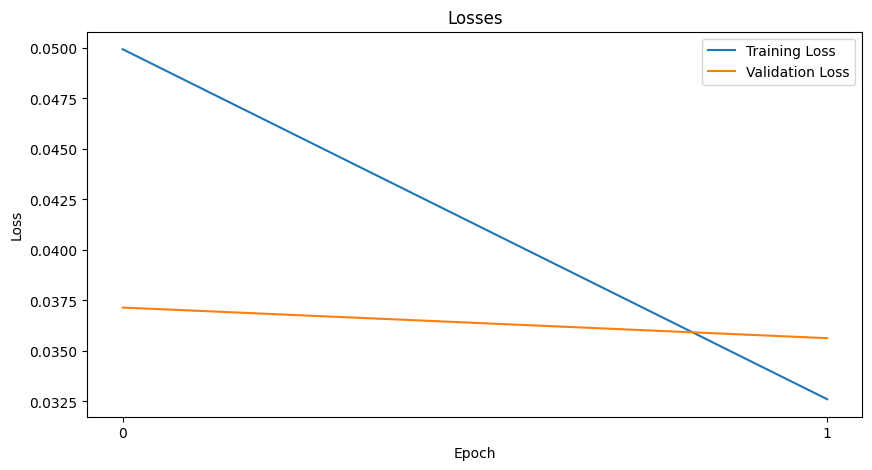

In [ ]:
if validation:
    # Plot Training and Validation losses
    def plot_losses(training_loss, val_loss):
        plt.figure(figsize=(10, 5))
        plt.plot(training_loss, label='Training Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.xticks(range(0, len(training_loss)))
        plt.title('Losses')
        plt.legend()
        plt.show()

    plot_losses(training_loss, val_loss)
else:
    print("No validation set was used.")

## Results
* **Mean ROC-AUC**: 0.9922
    * toxic: 0.9889
    * severe_toxic: 0.9915
    * obscene: 0.9952
    * threat: 0.9953
    * insult: 0.9904
    * identity_hate: 0.9921
* F1 Macro: 0.66

Also checked loss with an additional epoch and didn't improve.


This model (with Unweighted BCE Loss, gradient clipping and scheduler without any warmup) is our best model due to the superior efficiency.

## Save and Load model weights


In [ ]:
save_model = False # put it to True if you want to save actual model configuration

if save_model:
  # Define Folder
  if validation:
    folder = './DistilBERT_model_val'
  else:
    folder = './DistilBERT_model'

  # Export model
  model.save_pretrained(folder)
  # Export tokenizer
  tokenizer.save_pretrained(folder)

('./DistilBERT_model/tokenizer_config.json',
 './DistilBERT_model/special_tokens_map.json',
 './DistilBERT_model/vocab.txt',
 './DistilBERT_model/added_tokens.json')

In [ ]:
load_model = True # put it to True if you want to load model configuration

if load_model:
  # Define Folder
  if validation:
    folder = './DistilBERT_model_val'
  else:
    folder = './DistilBERT_model'

  # Create Folder if doesn't exist
  if not os.path.exists(folder):
    os.makedirs(folder)

  try:
    model = DistilBertForSequenceClassification.from_pretrained(folder)
    tokenizer = DistilBertTokenizer.from_pretrained(folder)
    model.to(DEVICE)
  except OSError:
    print(f'Model files not found.\nBe sure to have config.json, model.safetensors, tokenizer_config.json, special_tokens_map.json and vocab.txt inside {folder}')

In [ ]:
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


## Final Evaluation with Test Set

Generate predictions for the test set and evaluate for ROC-AUC and F1 Macro

In [ ]:
# Predictions for the test set
def predict(test_loader, model, DEVICE):
    predictions = []
    model.eval()
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_loader)):
            ids = data['input_ids'].to(DEVICE, dtype=torch.long)
            mask = data['attention_mask'].to(DEVICE, dtype=torch.long)

            outputs = model(input_ids = ids, attention_mask = mask)
            logits = outputs.logits

            predictions.extend(torch.sigmoid(logits).cpu().numpy())
    return np.array(predictions)

In [ ]:
predictions = predict(test_loader, model, DEVICE)
predictions = pd.DataFrame(predictions, columns=labels)
predictions.head()

1000it [07:45,  2.15it/s]


,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.000222,0.000026,0.000102,0.000074,0.000078,0.000071
1,0.559202,0.000321,0.003291,0.001464,0.026152,0.001440
2,0.368392,0.000486,0.048506,0.000532,0.025685,0.006276
3,0.000184,0.000014,0.000082,0.000030,0.000043,0.000043
4,0.000164,0.000014,0.000075,0.000031,0.000049,0.000040


In [ ]:
predictions.to_csv(folder + '/predictions.csv', index=False)

In [ ]:
# True labels of the test set
true_labels = pd.DataFrame(y_test, columns=labels)
true_labels

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
63973,0,0,0,0,0,0
63974,0,0,0,0,0,0
63975,0,0,0,0,0,0
63976,1,0,1,0,1,0


In [ ]:
# Evaluate ROC-AUC and classification report
auc = roc_auc_score(true_labels, predictions, average=None)
print("AUC per label:")
for i in range(len(labels)):
    print(f"{labels[i]}: {auc[i]:.4f}")
print(f"\nMean ROC-AUC: {auc.mean():.4f}")

y_pred = (predictions > 0.5).astype(int)
print(classification_report(true_labels, y_pred, target_names=labels, zero_division=0))

AUC per label:
toxic: 0.9746
severe_toxic: 0.9911
obscene: 0.9825
threat: 0.9961
insult: 0.9823
identity_hate: 0.9924

Mean ROC-AUC: 0.9865
               precision    recall  f1-score   support

        toxic       0.53      0.92      0.68      6090
 severe_toxic       0.42      0.43      0.42       367
      obscene       0.60      0.83      0.70      3691
       threat       0.53      0.52      0.53       211
       insult       0.66      0.78      0.71      3427
identity_hate       0.65      0.62      0.63       712

    micro avg       0.58      0.83      0.68     14498
    macro avg       0.57      0.68      0.61     14498
 weighted avg       0.58      0.83      0.68     14498
  samples avg       0.08      0.08      0.08     14498



## Results

### Training on complete Training Set

* **Mean ROC-AUC**: 0.9865
    * toxic: 0.9746
    * severe_toxic: 0.9911
    * obscene: 0.9825
    * threat: 0.9961
    * insult: 0.9823
    * identity_hate: 0.9924
* **F1 Macro**: 0.61

We also observed doubling the context length doubled the training time (from 11m to 23m) but obtained negligible performance gains (+0.0002 AUC). This suggests toxic features are predominantly found in the initial portion of the text.

Retraining on the full dataset improved the model's calibration, raising the AUC to 0.9865 and reaching the F1 Macro at 0.61.